# Advanced Lane Finding
---
---

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

---

## Calibrate a camera

### Run the code in the cell below to extract object points and image points for camera calibration.

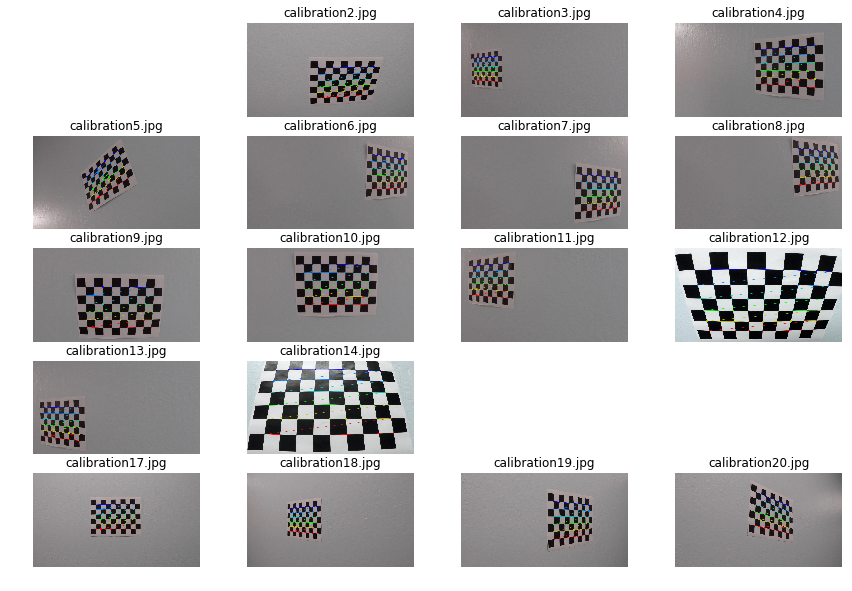

In [18]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

### Plot images after finding corners
fig = plt.figure(figsize=(15, 10))

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'camera_cal/corners/calibration' + str(idx+1) +'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        plt.subplot(5, 4, idx+1)
        plt.imshow(img)
        plt.title('calibration' + str(idx+1) +'.jpg')
        plt.axis('off')

cv2.destroyAllWindows()

fig.subplots_adjust(wspace=0.1, hspace=0.2)

plt.show()

### If the above cell ran sucessfully, you should now have objpoints and imgpoints needed for camera calibration. Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

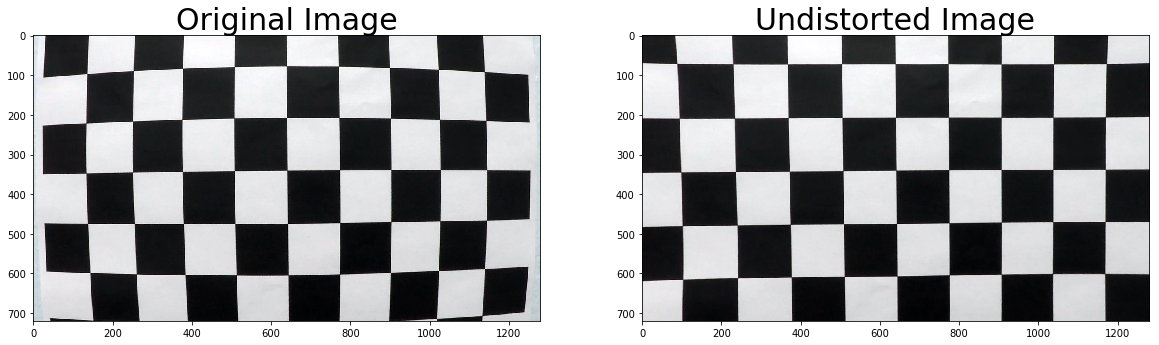

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undist/calibration1.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "pickles/calibration_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

---
## 2. Apply a distortion correction to raw images.
---

## Undistort Image

In [5]:
# undistort image using camera calibration matrix and distortion coefficients from above
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Apply undistort to a test image

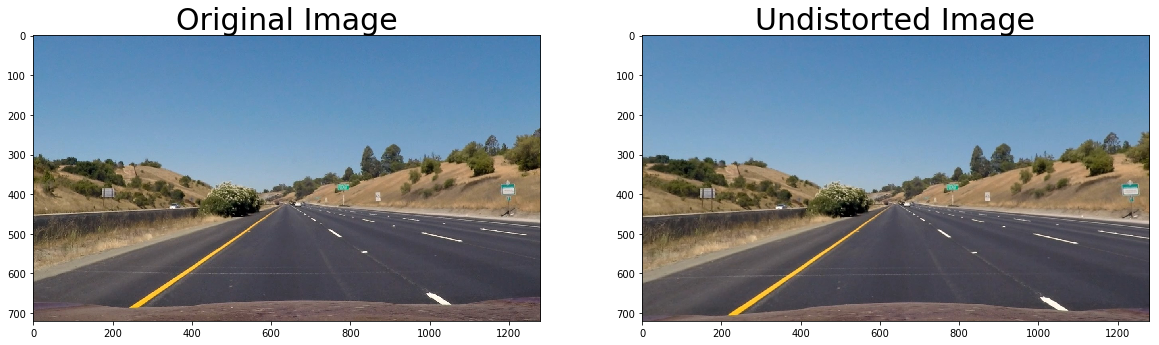

In [9]:
# Loading camera calibration pickle
cameraCalibration = pickle.load( open('pickles/calibration_pickle.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

# Test undistortion on an image
img = cv2.imread('test_images/straight_lines1.jpg')

dst = undistort(img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

---
## 3. Use color transforms, gradients, etc., to create a thresholded binary image.
---

In [54]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255), togray = False):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255), togray = False):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2), togray = False):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return dir_binary

In [55]:
def abs_sobel_thresh_hls(image, orient='x', sobel_kernel=3, thresh=(0, 255), togray = False):
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return grad_binary

def mag_thresh_hls(image, sobel_kernel=3, mag_thresh=(0, 255), togray = False):
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return mag_binary

def dir_threshold_hls(image, sobel_kernel=3, thresh=(0, np.pi/2), togray = False):
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return dir_binary

In [56]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [57]:
# Edit this function to create your own pipeline.
def color_grad_pipeline_hls(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh_hls(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh_hls(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh_hls(img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold_hls(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_binary = hls_select(img, thresh=(170, 255))
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary

In [58]:
# Edit this function to create your own pipeline.
def color_grad_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_binary = hls_select(img, thresh=(170, 255))
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary

In [59]:
# Edit this function to create your own pipeline.
def color_grad_pipeline_old(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

### Apply color transform and gradient to test image

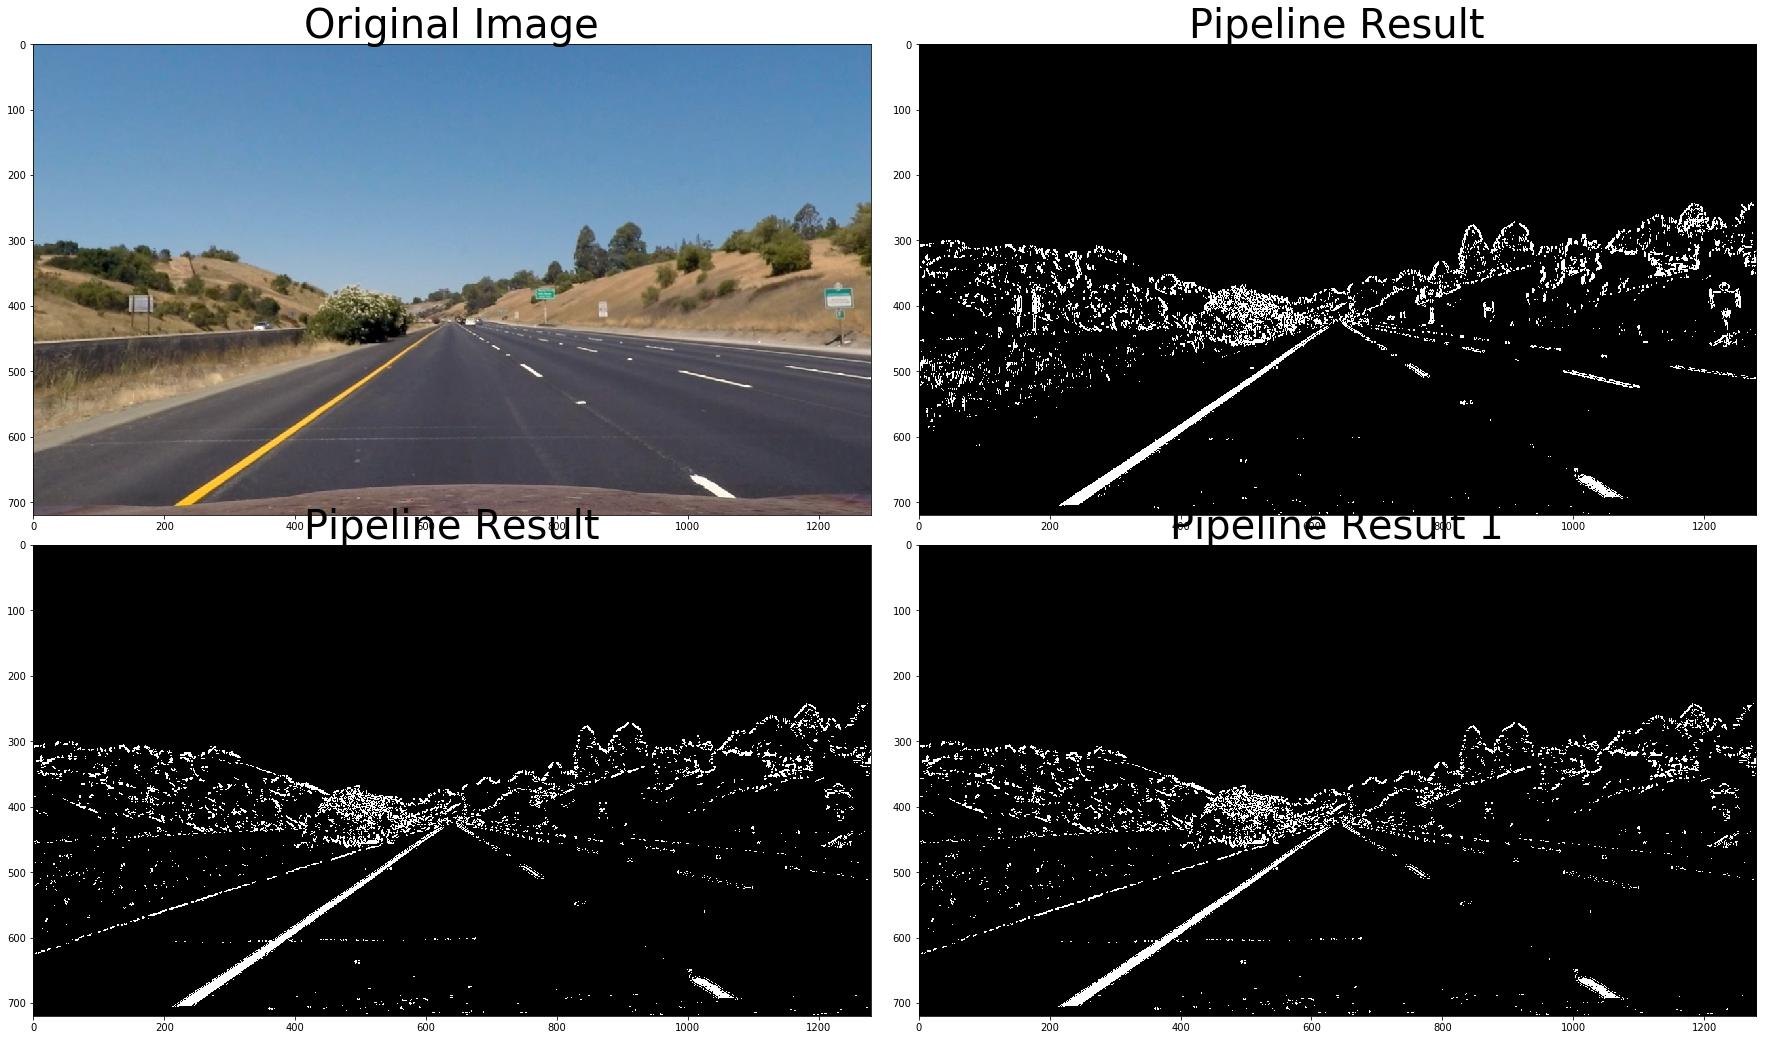

In [60]:
# Loading camera calibration pickle
cameraCalibration = pickle.load( open('pickles/calibration_pickle.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

# Test undistortion on an image
img = cv2.imread('test_images/straight_lines1.jpg')

dst = undistort(img, mtx, dist)

result = color_grad_pipeline_old(dst)

result1 = color_grad_pipeline(dst)

result2 = color_grad_pipeline_hls(dst)

# Plot the result
f, axes = plt.subplots(2, 2, figsize=(24, 15))
f.tight_layout()

axes[0,0].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Original Image', fontsize=40)

axes[0,1].imshow(result, cmap='gray')
axes[0,1].set_title('Pipeline Result', fontsize=40)

axes[1,0].imshow(result1, cmap='gray')
axes[1,0].set_title('Pipeline Result', fontsize=40)

axes[1,1].imshow(result2, cmap='gray')
axes[1,1].set_title('Pipeline Result 1', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## 4. Apply a perspective transform to rectify binary image ("birds-eye view").
---

In [137]:
def perspective_transform(img):
    #define perspective transform area
    img_size = (img.shape[1], img.shape[0])
    bot_width = .76 # percent of bottom trapezoid height
    mid_width = .08 # percent of middle trapezoid height
    height_pct = .62 # percent for trapezoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood
    
    #src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    
    src = np.float32([[0.46*img.shape[1],0.62*img.shape[0]],[0.54*img.shape[1],0.62*img.shape[0]],[0.88*img.shape[1],0.935*img.shape[0]],[0.12*img.shape[1],0.935*img.shape[0]]])
    
    
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    
    # perform the transform
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return src,warped

### Apply perspective transform to test image

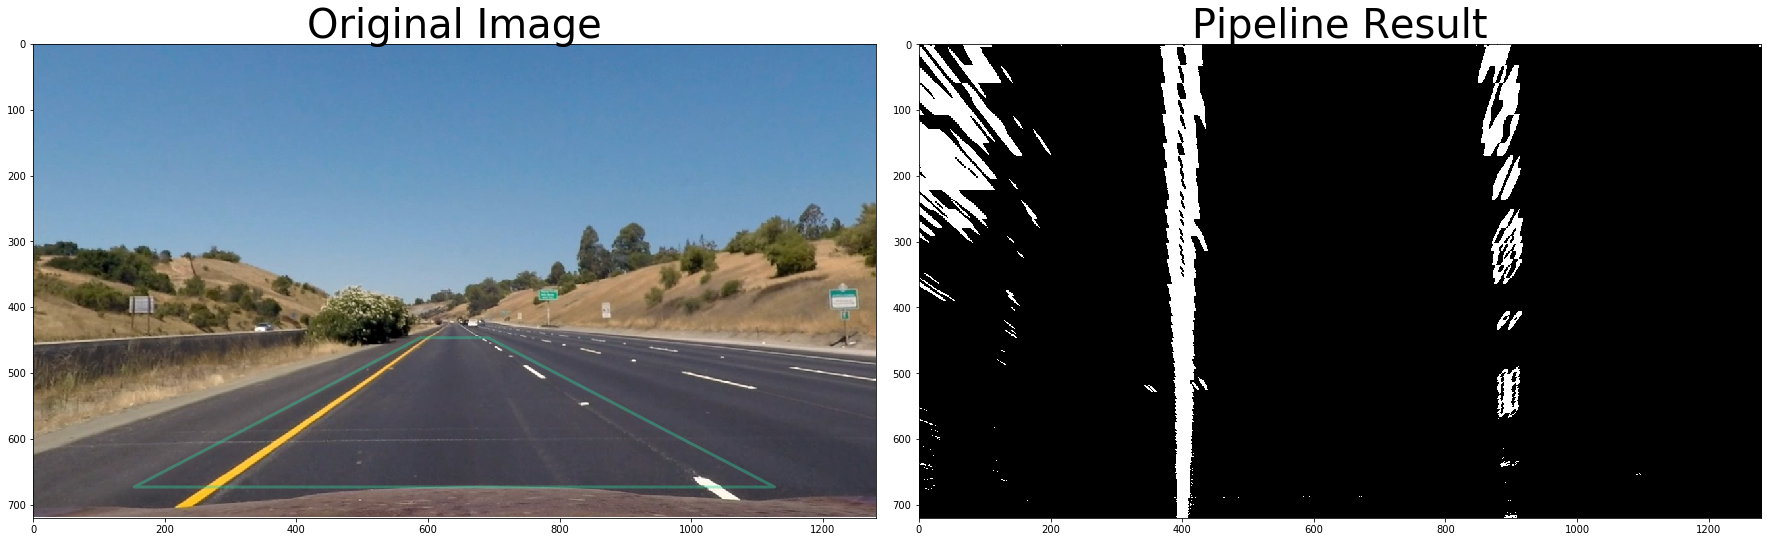

In [138]:
# Loading camera calibration pickle
cameraCalibration = pickle.load( open('pickles/calibration_pickle.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

# Test undistortion on an image
img = cv2.imread('test_images/straight_lines1.jpg')

dst = undistort(img, mtx, dist)

result = color_grad_pipeline_old(dst)

src,transformed = perspective_transform(result)

# Plot the result
f, axes = plt.subplots(1, 2, figsize=(24, 15))
f.tight_layout()

axes[0].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image', fontsize=40)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
axes[0].plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
axes[0].set_ylim([img.shape[0],0])
axes[0].set_xlim([0,img.shape[1]])

axes[1].imshow(transformed, cmap='gray')
axes[1].set_title('Pipeline Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## 5. Detect lane pixels and fit to find the lane boundary.
---

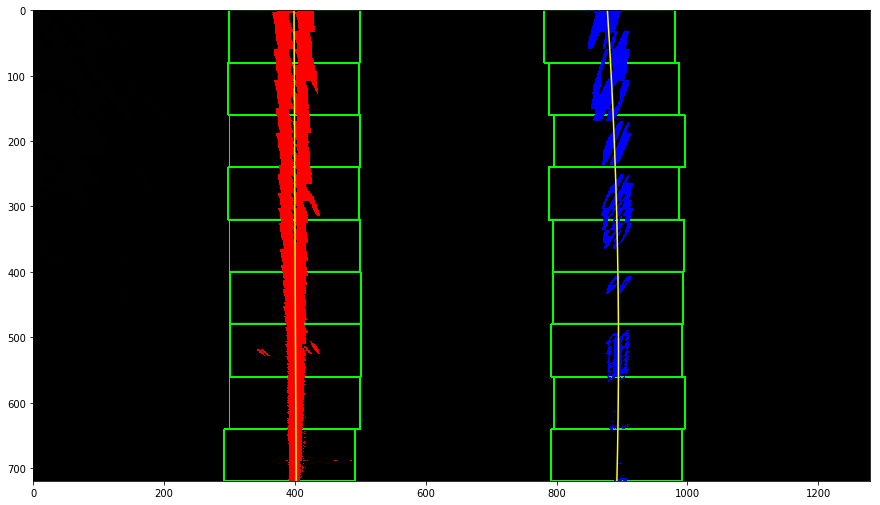

In [141]:
fig = plt.figure(figsize=(15, 10))
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

out_img = fit_polynomial(transformed)


plt.imshow(out_img)

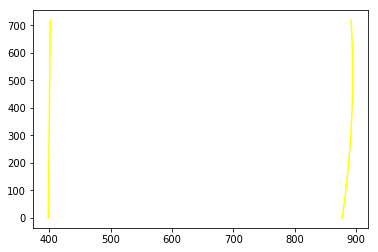

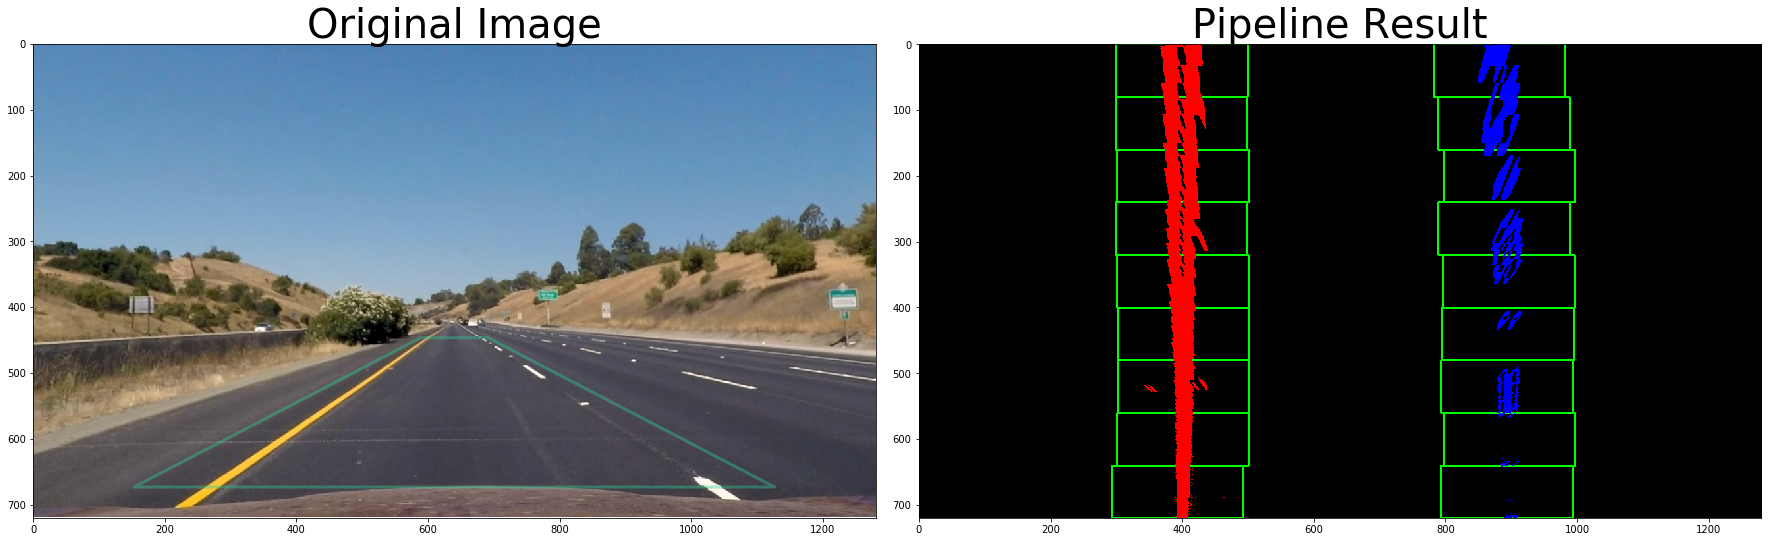

In [136]:
# Loading camera calibration pickle
cameraCalibration = pickle.load( open('pickles/calibration_pickle.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

# Test undistortion on an image
img = cv2.imread('test_images/straight_lines1.jpg')

dst = undistort(img, mtx, dist)

result = color_grad_pipeline_old(dst)

src,binary_warped = perspective_transform(result)

out_img = fit_polynomial(binary_warped)

# Plot the result
f, axes = plt.subplots(1, 2, figsize=(24, 15))
f.tight_layout()

axes[0].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image', fontsize=40)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
axes[0].plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
axes[0].set_ylim([img.shape[0],0])
axes[0].set_xlim([0,img.shape[1]])

axes[1].imshow(out_img, cmap='gray')
axes[1].set_title('Pipeline Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)